# Final Project Submission

Please fill out:

* Student name: Justin Grisanti
* Student pace: self-paced
* Scheduled project review date/time: 2/24/2022 @ TBD
* Instructor name: Claude Fried
* Blog post URL: TBD

# Section 1: Business Understanding


The purpose of this section is to define the business problem and understand the stakeholders for the work that I am performing. Mount Sinai is a hospital network in New York City. The Health System includes more than 6,600 primary and specialty care physicians and 13 ambulatory surgical centers.

For years, doctors at Mount Sinai review chest x-rays and try to determine whether there a patient has pneumonia. Pneumonia is an infection of the lung. The lungs fill with fluid and make breathing difficult. Pneumonia disproportionately affects the young, the elderly, and the immunocompromised. It preys on weakness and vulnerability. 

According to a 2010 study performed by the Henry Ford Health System, Pneumonia ranks second to congestive heart failure as the reason for readmission within 30 days of a previous hospitalization. Here are some important findings from the study:

* 72 percent of patients were misdiagnosed with pneumonia upon readmission to the same hospital.
* African-Americans were twice more likely than Caucasians to be misdiagnosed with pneumonia.
* Patients who smoke or have lung disease were likely to be misdiagnosed with pneumonia.
* 72 percent of the misdiagnoses occurred in the Emergency Department.
* Fewer than 33 percent of patients had any outpatient follow-up care prior to their readmission.

With these statistics in mind, Mount Sinai has contracted me to use deep learning to more accurately predict whether a patient has pneumonia, given a patient's chest x-ray.

The stakeholders of this project are patients, doctors, and radiologists.

The main purpose of this classification model is predictive, meaning that given a picture of a patients chest, the model should be able to predict whether that patient has pneumonia or not.

# Section 2: Data Understanding

The data downloaded has three different folders, train data, test data, and validation data. Across all of the folders, we have 5,856 chest x-rays for patients that have/don't have pneumonia. This data is useful/appropriate for solving our business problem. Let's import our packages and then begin analyzing our train dataset.

In [2]:
# Import necessary libraries

import pandas as pd
from numpy.random import seed
seed(123)
import numpy as np
import random
import shutil
import math
import statistics as stat
import os
import datetime
import seaborn as sns
import matplotlib.pyplot as plt
%matplotlib inline
import keras
import sklearn as sk
from sklearn import metrics
from sklearn.metrics import accuracy_score, f1_score, precision_score, confusion_matrix, classification_report
from sklearn.model_selection import KFold
from keras import models, layers, regularizers, metrics, backend
from keras.models import Sequential, load_model
from keras.layers import Dense
from keras.optimizers import SGD
from sklearn.preprocessing import StandardScaler, LabelBinarizer
from keras.preprocessing.image import ImageDataGenerator, array_to_img, img_to_array, load_img
from keras.callbacks import EarlyStopping, ModelCheckpoint
import pprint

Let's begin with analyzing our different chest x-ray images for our train, test and validation datasets. As we can see below, the lungs in our class 'normal' x-rays appear to be clearer than the lungs in our 'pneumonia' class, and it seems like it harder to see the heart as a result of this. However, because I am not a doctor, if I removed the labels and had to guess if a patient had pneumonia or not, I would probably do a fairly poor job. This is where deep learning comes in. We can use deep learning to analyze these images further to see if we are able to better predict whether a patient has pneumonia or not.

In [24]:
# Set important file paths, create variables for use in other areas

input_path = 'data/chest_xray/'

class_labels=['NORMAL','PNEUMONIA']
X=[]
Y=[]

train_path=input_path+'/train/'
validation_path=input_path+'/val/'
test_path=input_path+'/test/'

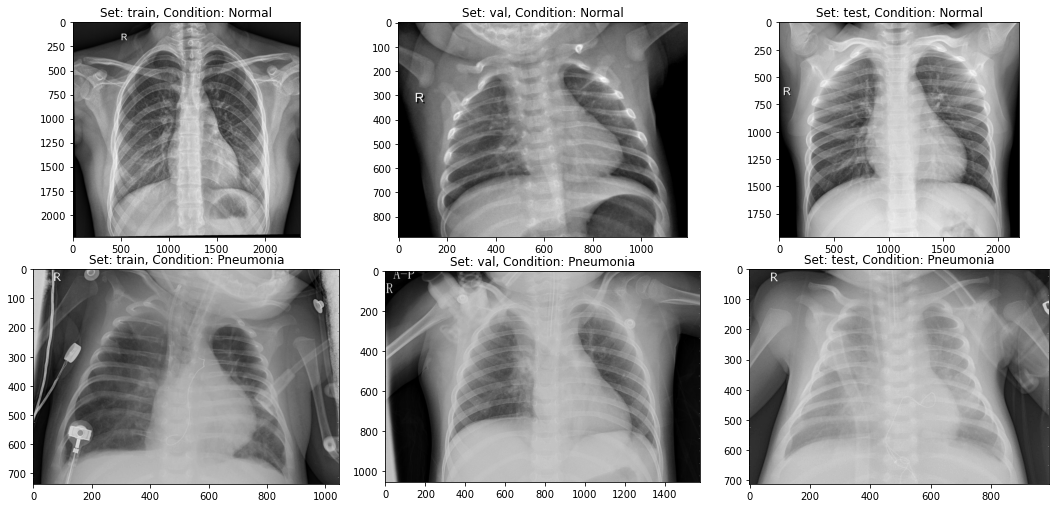

In [25]:
# Plot a sample from each folder, showing normal x-rays vs pneumonia x-rays

fig, ax = plt.subplots(2, 3, figsize=(15, 7))
ax = ax.ravel()
plt.tight_layout()

for i, _set in enumerate(['train', 'val', 'test']):
    set_path = input_path+_set
    ax[i].imshow(plt.imread(set_path+'/NORMAL/'+os.listdir(set_path+'/NORMAL')[0]), cmap='gray')
    ax[i].set_title('Set: {}, Condition: Normal'.format(_set))
    ax[i+3].imshow(plt.imread(set_path+'/PNEUMONIA/'+os.listdir(set_path+'/PNEUMONIA')[0]), cmap='gray')
    ax[i+3].set_title('Set: {}, Condition: Pneumonia'.format(_set))
plt.savefig('Visualizations/chestxrays.png', bbox_inches = 'tight')

Now, I will analyze our population:

In [6]:
# Hashing this code, as the initial population has been changed

#total_image_count = []
#ill_image_count = []
#normal_image_count = []

#for _set in ['train','val', 'test']:
#    total_image_count.append(len(os.listdir(input_path + _set + '/NORMAL')))
#    total_image_count.append(len(os.listdir(input_path + _set + '/PNEUMONIA')))
#    normal_image_count.append(len(os.listdir(input_path + _set + '/NORMAL')))
#    ill_image_count.append(len(os.listdir(input_path + _set + '/PNEUMONIA')))
#    print(_set + '/NORMAL:', len(os.listdir(input_path + _set + '/NORMAL')))
#    print(_set + '/PNEUMONIA:',len(os.listdir(input_path + _set + '/PNEUMONIA')))

#print('\nValue Counts: \nNormal:',sum(normal_image_count)/sum(total_image_count), '\nPneumonia:',sum(ill_image_count)/sum(total_image_count))
#print('\nPopulation Breakdown: \nTrain:', (len(os.listdir(input_path + '/train/NORMAL'))+len(os.listdir(input_path + '/train/PNEUMONIA')))/5856,'\nTest:',(len(os.listdir(input_path + '/test/NORMAL'))+len(os.listdir(input_path + '/test/PNEUMONIA')))/5856,'\nVal:',(len(os.listdir(input_path + '/val/NORMAL'))+len(os.listdir(input_path + '/val/PNEUMONIA')))/5856)

#print('\nSum: ',sum(total_image_count))

train/NORMAL: 1341 <br>
train/PNEUMONIA: 3875<br>
val/NORMAL: 8<br>
val/PNEUMONIA: 8<br>
test/NORMAL: 234<br>
test/PNEUMONIA: 390<br>
<br><br>
Value Counts: <br>
Normal: 0.2703210382513661 <br>
Pneumonia: 0.7296789617486339<br>
<br><br>
Population Breakdown: <br>
Train: 0.8907103825136612 <br>
Test: 0.10655737704918032 <br>
Val: 0.00273224043715847<br>
<br><br>
Sum:  5856

Above, we can see our total population is broken down as 27% normal chest x-rays, and 73% pneumonia chest x-rays. If our model were to randomly guess all class 1, a 73% accuracy rate would be expected. We should expect a good model to have an accuracy rating that is better than 73%. Also, our train, test and val population is split by 89.1%, 10.7% and .2%, respectively. I am going to use K-Fold Cross Validation on the train dataset. To even our population, I want to move some data to our test folder for validation when we fit the model, and also want to move data to our validation folder for our final model.

In [6]:
# To move images between folders

def move_img(input_source,input_dest,weight):
    files = os.listdir(input_source)
    num_files=int(len(os.listdir(input_source))*weight)
    for file_name in random.sample(files, num_files):
        shutil.move(os.path.join(input_source, file_name), input_dest)

In [7]:
# I move 2% of our images to our validation folders

# move_img(train_path+'/NORMAL',validation_path+'NORMAL',.02)
# move_img(train_path+'/PNEUMONIA',validation_path+'/PNEUMONIA',.02)

In [17]:
# I move all of our of our images to our train folders

# move_img(test_path+'/NORMAL',train_path+'NORMAL',1)
# move_img(test_path+'/PNEUMONIA',train_path+'/PNEUMONIA',1)

In [18]:
# I randomly move 20% of our images to our test folders

# move_img(train_path+'/NORMAL',test_path+'NORMAL',.2)
# move_img(train_path+'/PNEUMONIA',test_path+'/PNEUMONIA',.2)

In [45]:
# Check population information

total_image_count = []
ill_image_count = []
normal_image_count = []

for _set in ['train','val', 'test']:
    total_image_count.append(len(os.listdir(input_path + _set + '/NORMAL')))
    total_image_count.append(len(os.listdir(input_path + _set + '/PNEUMONIA')))
    normal_image_count.append(len(os.listdir(input_path + _set + '/NORMAL')))
    ill_image_count.append(len(os.listdir(input_path + _set + '/PNEUMONIA')))
    print(_set + '/NORMAL:', len(os.listdir(input_path + _set + '/NORMAL')))
    print(_set + '/PNEUMONIA:',len(os.listdir(input_path + _set + '/PNEUMONIA')))

print('\nValue Counts: \nNormal:',sum(normal_image_count)/sum(total_image_count), '\nPneumonia:',sum(ill_image_count)/sum(total_image_count))
print('\nPopulation Breakdown: \nTrain:', (len(os.listdir(input_path + '/train/NORMAL'))+len(os.listdir(input_path + '/train/PNEUMONIA')))/5856,'\nTest:',(len(os.listdir(input_path + '/test/NORMAL'))+len(os.listdir(input_path + '/test/PNEUMONIA')))/5856,'\nVal:',(len(os.listdir(input_path + '/val/NORMAL'))+len(os.listdir(input_path + '/val/PNEUMONIA')))/5856)

print('\nSum: ',sum(total_image_count))

train/NORMAL: 1240
train/PNEUMONIA: 3351
val/NORMAL: 34
val/PNEUMONIA: 85
test/NORMAL: 309
test/PNEUMONIA: 837

Value Counts: 
Normal: 0.2703210382513661 
Pneumonia: 0.7296789617486339

Population Breakdown: 
Train: 0.7839822404371585 
Test: 0.19569672131147542 
Val: 0.02032103825136612

Sum:  5856


In [27]:
# Combine lists for graphing purposes

population = [sum(normal_image_count),sum(ill_image_count)]

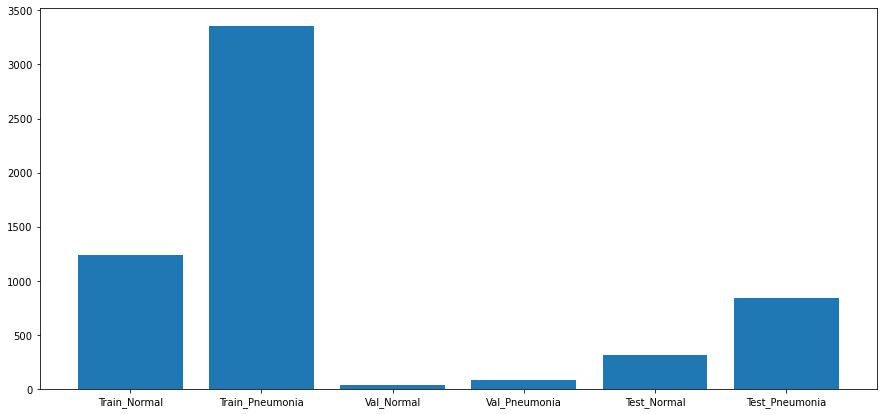

In [28]:
# Plot populations by folder

labels = ['Train_Normal','Train_Pneumonia','Val_Normal','Val_Pneumonia','Test_Normal','Test_Pneumonia']
fig, ax = plt.subplots(figsize=(15, 7))
ax.bar(x=labels, height=total_image_count)
plt.savefig('Visualizations/FolderPopulation.png', bbox_inches = 'tight')

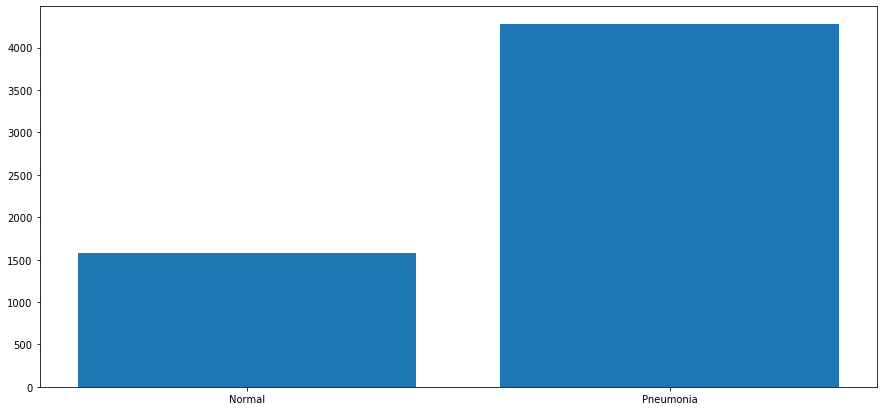

In [29]:
# Plot population by class

labels_2 = ['Normal','Pneumonia']
fig, ax = plt.subplots(figsize=(15, 7))
ax.bar(x=labels_2, height=population)
plt.savefig('Visualizations/ClassPopulation.png', bbox_inches = 'tight')

# Section 3: Data Preparation

Now, I am going to prepare each image by converting the picture into an array of numbers using ImageDataGenerator. Because I am using KFold cross validation, I will need to prepare our train data into an X and Y array.

In [30]:
# Creating labels for our train data and separating it into X and Y lists for our KFold CV

def prepare_arrays(folder_name):
    train_files=os.listdir(input_path+'/train/'+folder_name)
    for i in train_files:
        X.append(i)
        for i in range(len(class_labels)):
            if(folder_name==class_labels[i]):
                Y.append(i)

In [31]:
# Assigning labels to images

for i in range(len(class_labels)):
    prepare_arrays(class_labels[i])

In [32]:
# Creating X and Y arrays on train data for cross validation

X=np.asarray(X)
Y=np.asarray(Y)

In [33]:
print(X.shape)
print(Y.shape)

(4591,)
(4591,)


In [34]:
# get all the data in the directory split/test (1146 images), and reshape them
test_generator = ImageDataGenerator(rescale=1./255).flow_from_directory(
        'data/chest_xray/test', 
        target_size=(64, 64), batch_size = 1146) 

# get all the data in the directory split/validation (119 images), and reshape them
val_generator = ImageDataGenerator(rescale=1./255).flow_from_directory(
        'data/chest_xray/val', 
        target_size=(64, 64), batch_size = 119)

# get all the data in the directory split/train (4591 images), and reshape them
train_generator = ImageDataGenerator(rescale=1./255).flow_from_directory(
        'data/chest_xray/train', 
        target_size=(64, 64), batch_size=4591)

Found 1146 images belonging to 2 classes.
Found 119 images belonging to 2 classes.
Found 4591 images belonging to 2 classes.


In [35]:
# Separate our images into 2 sets of arrays: 
# Images-translates image to numeric format
# Labels- labels image as 0 or 1 (normal vs pneumonia)

train_images, train_labels = next(train_generator)
test_images, test_labels = next(test_generator)
val_images, val_labels = next(val_generator)

In [36]:
# To illustrate information about each array created

m_train = train_images.shape[0]
num_px = train_images.shape[1]
m_test = test_images.shape[0]
m_val = val_images.shape[0]

print ("Number of training samples: " + str(m_train))
print ("Number of testing samples: " + str(m_test))
print ("Number of validation samples: " + str(m_val))
print ("train_images shape: " + str(train_images.shape))
print ("train_labels shape: " + str(train_labels.shape))
print ("test_images shape: " + str(test_images.shape))
print ("test_labels shape: " + str(test_labels.shape))
print ("val_images shape: " + str(val_images.shape))
print ("val_labels shape: " + str(val_labels.shape))

Number of training samples: 4591
Number of testing samples: 1146
Number of validation samples: 119
train_images shape: (4591, 64, 64, 3)
train_labels shape: (4591, 2)
test_images shape: (1146, 64, 64, 3)
test_labels shape: (1146, 2)
val_images shape: (119, 64, 64, 3)
val_labels shape: (119, 2)


In [37]:
# Collapsing image arrays into 2D array

X_train = train_images.reshape(train_images.shape[0], -1)
X_test = test_images.reshape(test_images.shape[0], -1)
X_val = val_images.reshape(val_images.shape[0], -1)

print(X_train.shape)
print(X_test.shape)
print(X_val.shape)

(4591, 12288)
(1146, 12288)
(119, 12288)


In [38]:
# Collapsing label arrays into 1D array

y_train = np.reshape(train_labels[:,0], (4591,1))
y_test = np.reshape(test_labels[:,0], (1146,1))
y_val = np.reshape(val_labels[:,0], (119,1))

print(y_train.shape)
print(y_test.shape)
print(y_val.shape)

(4591, 1)
(1146, 1)
(119, 1)


# Section 4: Modeling

Now that our images have been pre-processed and transformed into arrays that we can work with, we can now run a baseline model. The main metric I will be using is accuracy, however, upon evaluation I will be focusing on recall as false negatives are the reason why pneumonia patients are readmitted to the hospital.

### Baseline Model:

In [39]:
# Creating function to depict fit results and graph train accuracy/loss against test accuracy/loss 

def model_results(model, model_fit):
    
    model_func = model
    model_fit_func = model_fit
    results_train = model_func.evaluate(X_train, y_train)
    results_test = model_func.evaluate(X_test, y_test)
    
    model_val_dict = model_fit_func.history
    model_val_dict.keys()

    loss_values = model_val_dict['loss']
    val_loss_values = model_val_dict['val_loss']
    acc_values = model_val_dict['acc'] 
    val_acc_values = model_val_dict['val_acc']
    epochs = range(1, len(loss_values) + 1)
    
    fig, (ax, ax2) = plt.subplots(nrows=2, ncols=1, figsize=(12, 12))
    
    ax.plot(epochs, loss_values, label='Training loss')
    ax.plot(epochs, val_loss_values, label='Test loss')
    ax.set_title('Training & Testing loss')
    ax.set_xlabel('Epochs')
    ax.set_ylabel('Loss')
    ax.legend();

    ax2.plot(epochs, acc_values, label='Training acc')
    ax2.plot(epochs, val_acc_values, label='Test acc')
    ax2.set_title('Training & Testing accuracy')
    ax2.set_xlabel('Epochs')
    ax2.set_ylabel('Accuracy')
    ax2.legend();
    

    return print("\nTrain Results (Loss, Acc.):", results_train), print("Test Results (Loss, Acc.):", results_test)

In [40]:
# Create simple baseline model to check accuracy and loss

baseline_model = models.Sequential()
baseline_model.add(layers.Dense(10, activation='relu', input_shape=(12288,)))
baseline_model.add(layers.Dense(4, activation='sigmoid'))
baseline_model.add(layers.Dense(1, activation='sigmoid'))
baseline_model.compile(optimizer="sgd",
                           loss='binary_crossentropy',
                           metrics=['accuracy'])

baseline_model_fit = baseline_model.fit(X_train,
                                            y_train,
                                            epochs=50,
                                            batch_size=32,
                                            validation_data=(X_test, y_test)) # Validate using test data

Train on 4591 samples, validate on 1146 samples
Epoch 1/50
4591/4591 [==============================] - 0s 97us/step - loss: 0.5418 - acc: 0.7299 - val_loss: 0.4956 - val_acc: 0.7304
Epoch 2/50
4591/4591 [==============================] - 0s 104us/step - loss: 0.4574 - acc: 0.7737 - val_loss: 0.4246 - val_acc: 0.7967
Epoch 3/50
4591/4591 [==============================] - 0s 69us/step - loss: 0.3977 - acc: 0.8582 - val_loss: 0.3842 - val_acc: 0.9031
Epoch 4/50
4591/4591 [==============================] - 0s 64us/step - loss: 0.3568 - acc: 0.8874 - val_loss: 0.3493 - val_acc: 0.8674
Epoch 5/50
4591/4591 [==============================] - 0s 66us/step - loss: 0.3221 - acc: 0.9044 - val_loss: 0.3043 - val_acc: 0.9084
Epoch 6/50
4591/4591 [==============================] - 0s 60us/step - loss: 0.2960 - acc: 0.9103 - val_loss: 0.2756 - val_acc: 0.9206
Epoch 7/50
4591/4591 [==============================] - 0s 69us/step - loss: 0.2727 - acc: 0.9161 - val_loss: 0.2738 - val_acc: 0.9058
Epoch 

1146/1146 [==============================] - 0s 30us/step

Train Results (Loss, Acc.): [0.17525029354620228, 0.9313874972902646]
Test Results (Loss, Acc.): [0.2131096540607291, 0.9258289703315882]


(None, None)

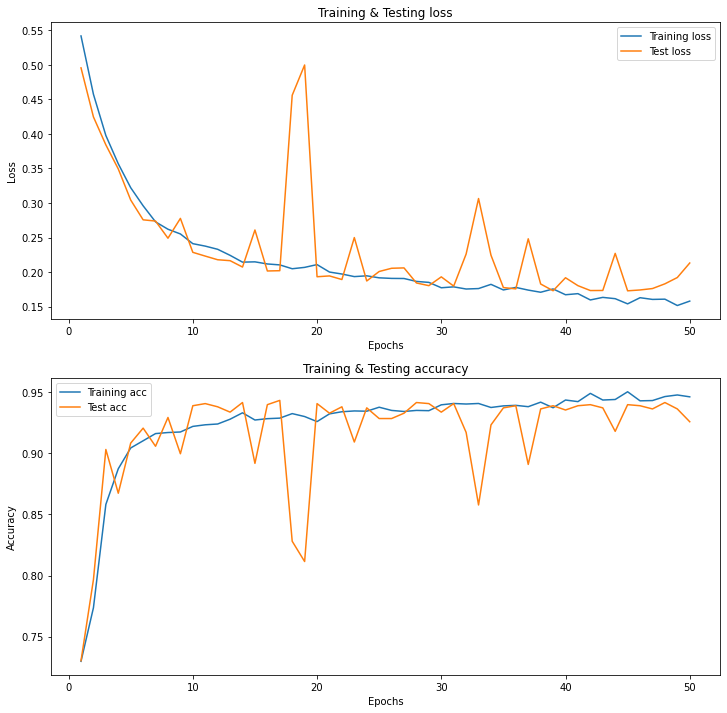

In [41]:
# Call function for information

model_results(baseline_model,baseline_model_fit)

As we can see above, our baseline model seems to be performing great in terms of accuracy and loss, and there doesn't appear to be overfitting between our train and test data. According to Francois Chollet, there are 4 ways we can reduce overfitting:

* Get more training data
* Reduce the capacity of the network
* Add weight regularization
* Add dropout
 
To see if our model performs better, I will add hidden layers, add regularizers, add dropout, and perform KFold Cross Validation.

### Model 1 - Add Hidden Layers, Regularization, and Dropout:

In [42]:
# Creating new function comparing new model to baseline model

def compare_model_results(baseline_model, baseline_model_fit, model, model_fit):
    
    model_baseline = baseline_model
    model_baseline_fit = baseline_model_fit
    model_func = model
    model_fit_func = model_fit
    results_train_baseline = model_baseline.evaluate(X_train, y_train)
    results_test_baseline = model_baseline.evaluate(X_test, y_test)
    results_train_model = model_func.evaluate(X_train, y_train)
    results_test_model = model_func.evaluate(X_test, y_test)
    
    baseline_model_val_dict = model_baseline_fit.history
    baseline_model_val_dict.keys()
    model_val_dict = model_fit_func.history
    model_val_dict.keys()

    model_loss_values = model_val_dict['loss']
    model_val_loss_values = model_val_dict['val_loss']
    model_acc_values = model_val_dict['acc'] 
    model_val_acc_values = model_val_dict['val_acc']
    model_epochs = range(1, len(model_loss_values) + 1)
    
    baseline_loss_values = baseline_model_val_dict['loss']
    baseline_val_loss_values = baseline_model_val_dict['val_loss']
    baseline_acc_values = baseline_model_val_dict['acc'] 
    baseline_val_acc_values = baseline_model_val_dict['val_acc']
    baseline_epochs = range(1, len(baseline_loss_values) + 1)
    
    fig, (ax, ax2) = plt.subplots(nrows=2, ncols=1, figsize=(20, 25))
    
    ax.plot(model_epochs, model_loss_values, label='Training loss (Model)')
    ax.plot(model_epochs, model_val_loss_values, label='Testing loss (Model)')
    ax.plot(baseline_epochs, baseline_loss_values, label='Training loss (Baseline)')
    ax.plot(baseline_epochs, baseline_val_loss_values, label='Testing loss (Baseline)')
    ax.set_title('Training & Testing Loss Current Model vs Baseline')
    ax.set_xlabel('Epochs')
    ax.set_ylabel('Loss')
    ax.legend();

    ax2.plot(model_epochs, model_acc_values, label='Training acc (Model)')
    ax2.plot(model_epochs, model_val_acc_values, label='Testing acc (Model)')
    ax2.plot(baseline_epochs, baseline_acc_values, label='Training acc (Baseline)')
    ax2.plot(baseline_epochs, baseline_val_acc_values, label='Testing acc (Baseline)')
    ax2.set_title('Training & Testing Accuracy Current Model vs Baseline')
    ax2.set_xlabel('Epochs')
    ax2.set_ylabel('Accuracy')
    ax2.legend();
    
    return print("\nBaseline Model Train Results (Loss, Acc.):", results_train_baseline), print("Baseline Model Test Results (Loss, Acc.):", results_test_baseline), print("\nCurrent Model Train Results (Loss, Acc.):", results_train_model), print("Current Model Test Results (Loss, Acc.):", results_test_model)

Results for fold 1
Train on 4591 samples, validate on 1146 samples
Epoch 1/50
4591/4591 [==============================] - 1s 175us/step - loss: 0.6858 - acc: 0.6855 - val_loss: 0.5665 - val_acc: 0.7304
Epoch 2/50
4591/4591 [==============================] - 0s 105us/step - loss: 0.5312 - acc: 0.7195 - val_loss: 0.4273 - val_acc: 0.7304
Epoch 3/50
4591/4591 [==============================] - 0s 98us/step - loss: 0.4684 - acc: 0.7271 - val_loss: 0.4304 - val_acc: 0.7304
Epoch 4/50
4591/4591 [==============================] - 0s 94us/step - loss: 0.4402 - acc: 0.7271 - val_loss: 0.4418 - val_acc: 0.7304
Epoch 5/50
4591/4591 [==============================] - 1s 147us/step - loss: 0.4166 - acc: 0.8676 - val_loss: 0.3536 - val_acc: 0.9119
Epoch 6/50
4591/4591 [==============================] - 0s 105us/step - loss: 0.3909 - acc: 0.8839 - val_loss: 0.3334 - val_acc: 0.9276
Epoch 7/50
4591/4591 [==============================] - 1s 138us/step - loss: 0.3605 - acc: 0.8769 - val_loss: 0.2796 -

4591/4591 [==============================] - 1s 144us/step - loss: 0.3895 - acc: 0.8924 - val_loss: 0.3306 - val_acc: 0.9049
Epoch 6/50
4591/4591 [==============================] - 1s 123us/step - loss: 0.3730 - acc: 0.8870 - val_loss: 0.3974 - val_acc: 0.8656
Epoch 7/50
4591/4591 [==============================] - 1s 130us/step - loss: 0.3571 - acc: 0.8917 - val_loss: 0.4073 - val_acc: 0.8403
Epoch 8/50
4591/4591 [==============================] - 1s 129us/step - loss: 0.3478 - acc: 0.8959 - val_loss: 0.3344 - val_acc: 0.9066
Epoch 9/50
4591/4591 [==============================] - 1s 137us/step - loss: 0.3400 - acc: 0.8952 - val_loss: 0.3067 - val_acc: 0.9171
Epoch 10/50
4591/4591 [==============================] - 1s 109us/step - loss: 0.3563 - acc: 0.8832 - val_loss: 0.2802 - val_acc: 0.9241
Epoch 11/50
4591/4591 [==============================] - 1s 126us/step - loss: 0.3389 - acc: 0.8974 - val_loss: 0.2762 - val_acc: 0.9232
Epoch 12/50
4591/4591 [==============================] - 

4591/4591 [==============================] - 0s 103us/step - loss: 0.2933 - acc: 0.9142 - val_loss: 0.2391 - val_acc: 0.9363
Epoch 10/50
4591/4591 [==============================] - 0s 105us/step - loss: 0.2836 - acc: 0.9164 - val_loss: 0.2373 - val_acc: 0.9267
Epoch 11/50
4591/4591 [==============================] - 1s 131us/step - loss: 0.2596 - acc: 0.9253 - val_loss: 0.2693 - val_acc: 0.9197
Epoch 12/50
4591/4591 [==============================] - 1s 114us/step - loss: 0.2661 - acc: 0.9220 - val_loss: 0.2378 - val_acc: 0.9415
Epoch 13/50
4591/4591 [==============================] - 1s 119us/step - loss: 0.2721 - acc: 0.9246 - val_loss: 0.2752 - val_acc: 0.9188
Epoch 14/50
4591/4591 [==============================] - 1s 144us/step - loss: 0.2668 - acc: 0.9218 - val_loss: 0.2326 - val_acc: 0.9442
Epoch 15/50
4591/4591 [==============================] - 0s 107us/step - loss: 0.2619 - acc: 0.9238 - val_loss: 0.2274 - val_acc: 0.9398
Epoch 16/50
4591/4591 [==============================

4591/4591 [==============================] - 1s 121us/step - loss: 0.2861 - acc: 0.9164 - val_loss: 0.2382 - val_acc: 0.9232
Epoch 14/50
4591/4591 [==============================] - 1s 109us/step - loss: 0.2815 - acc: 0.9192 - val_loss: 0.2292 - val_acc: 0.9424
Epoch 15/50
4591/4591 [==============================] - 1s 110us/step - loss: 0.2728 - acc: 0.9275 - val_loss: 0.2560 - val_acc: 0.9127
Epoch 16/50
4591/4591 [==============================] - 1s 146us/step - loss: 0.2710 - acc: 0.9198 - val_loss: 0.2270 - val_acc: 0.9450
Epoch 17/50
4591/4591 [==============================] - 1s 113us/step - loss: 0.2727 - acc: 0.9292 - val_loss: 0.2287 - val_acc: 0.9442
Epoch 18/50
4591/4591 [==============================] - 0s 103us/step - loss: 0.2728 - acc: 0.9174 - val_loss: 0.5720 - val_acc: 0.7740
Epoch 19/50
4591/4591 [==============================] - 0s 99us/step - loss: 0.2716 - acc: 0.9242 - val_loss: 0.3733 - val_acc: 0.8639
Epoch 20/50
4591/4591 [==============================]

4591/4591 [==============================] - 0s 100us/step - loss: 0.2547 - acc: 0.9281 - val_loss: 0.2344 - val_acc: 0.9346
Epoch 18/50
4591/4591 [==============================] - 0s 105us/step - loss: 0.2544 - acc: 0.9257 - val_loss: 0.2312 - val_acc: 0.9302
Epoch 19/50
4591/4591 [==============================] - 0s 99us/step - loss: 0.2510 - acc: 0.9275 - val_loss: 0.3014 - val_acc: 0.9058
Epoch 20/50
4591/4591 [==============================] - 0s 98us/step - loss: 0.2529 - acc: 0.9349 - val_loss: 0.2216 - val_acc: 0.9363
Epoch 21/50
4591/4591 [==============================] - 0s 92us/step - loss: 0.2464 - acc: 0.9338 - val_loss: 0.2196 - val_acc: 0.9415
Epoch 22/50
4591/4591 [==============================] - 0s 101us/step - loss: 0.2503 - acc: 0.9288 - val_loss: 0.2698 - val_acc: 0.9284
Epoch 23/50
4591/4591 [==============================] - 0s 103us/step - loss: 0.2611 - acc: 0.9251 - val_loss: 0.2397 - val_acc: 0.9328
Epoch 24/50
4591/4591 [==============================] -

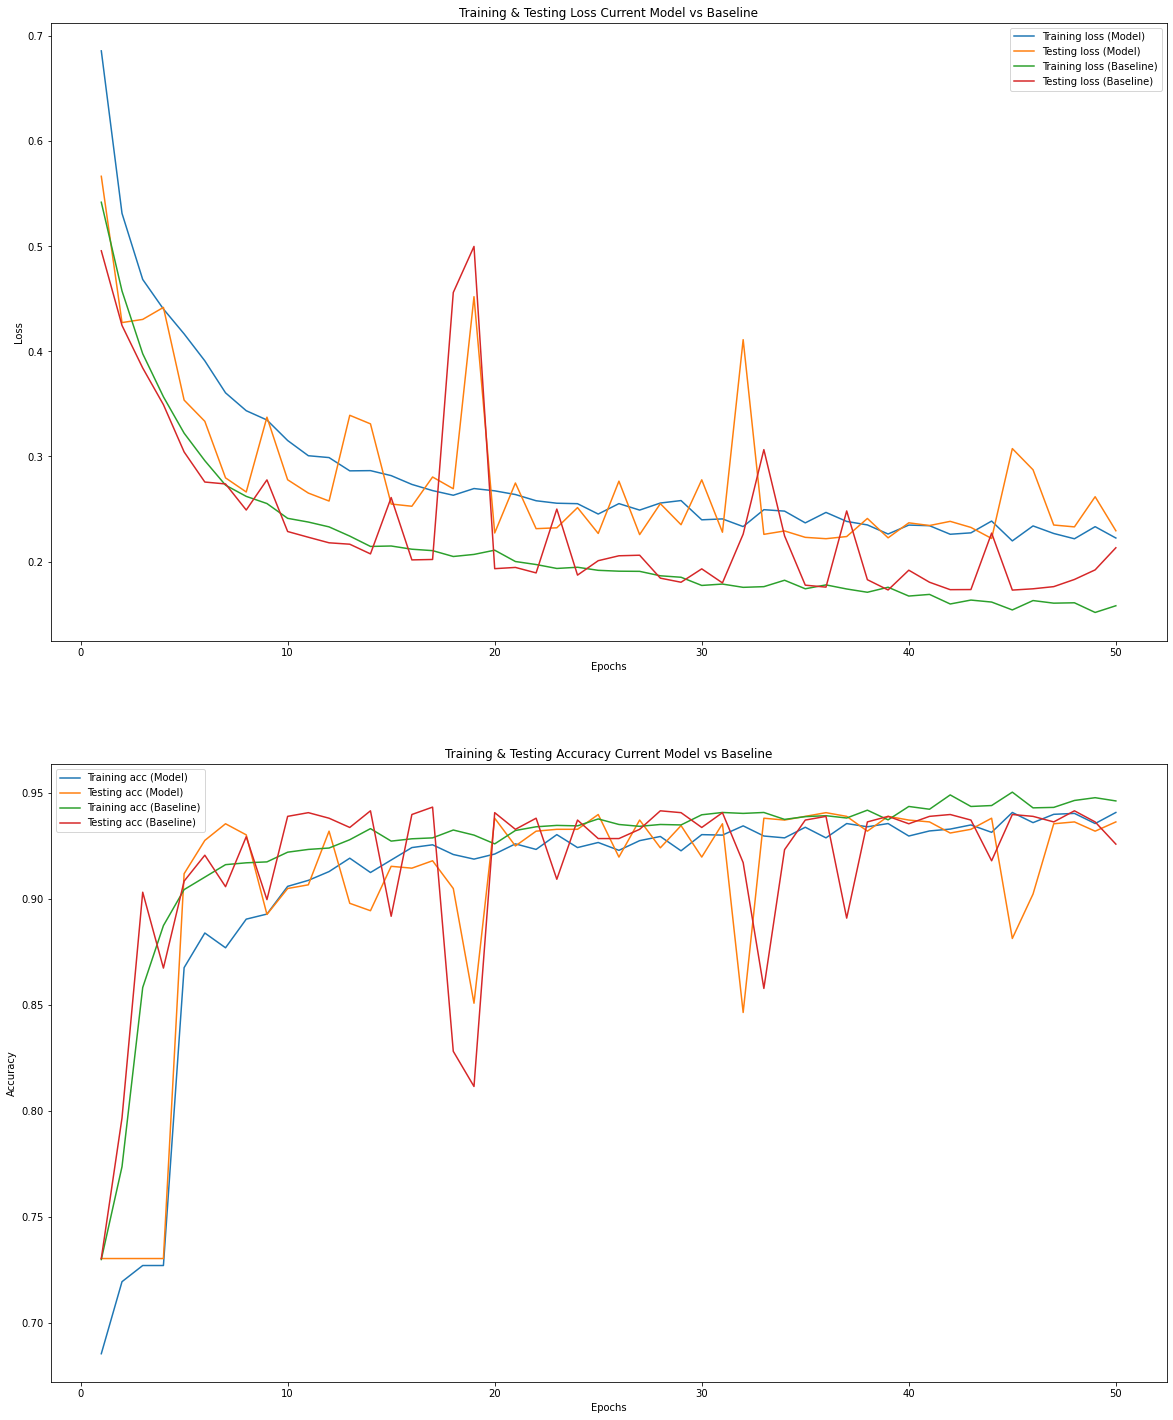

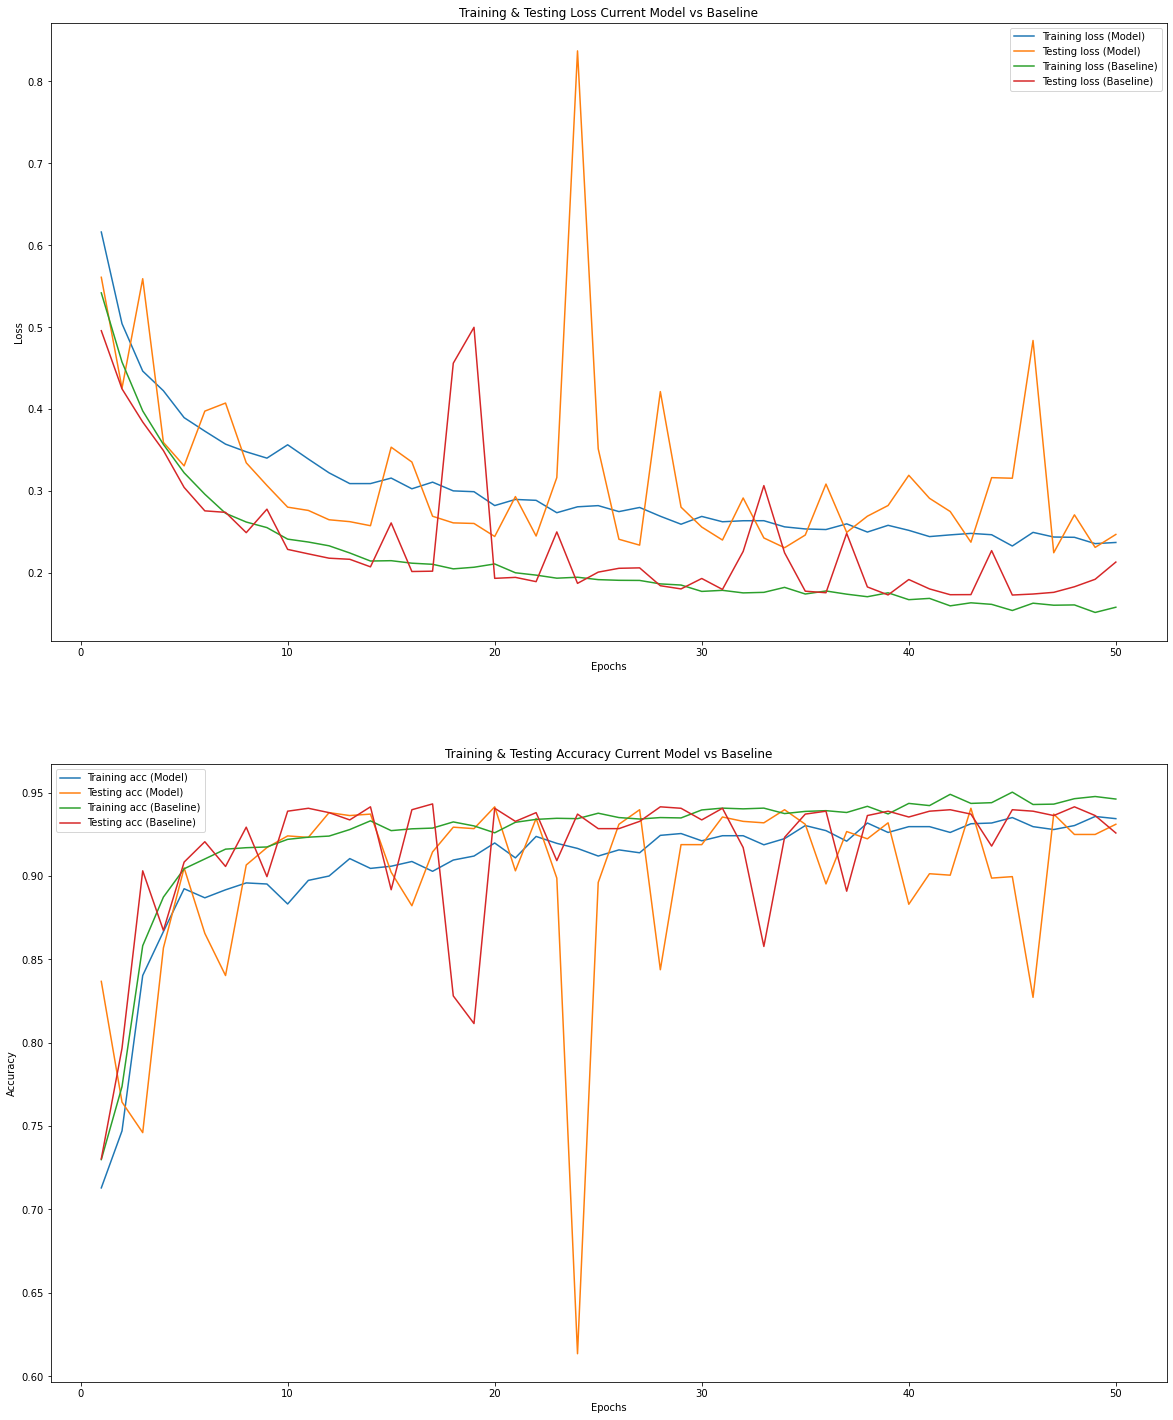

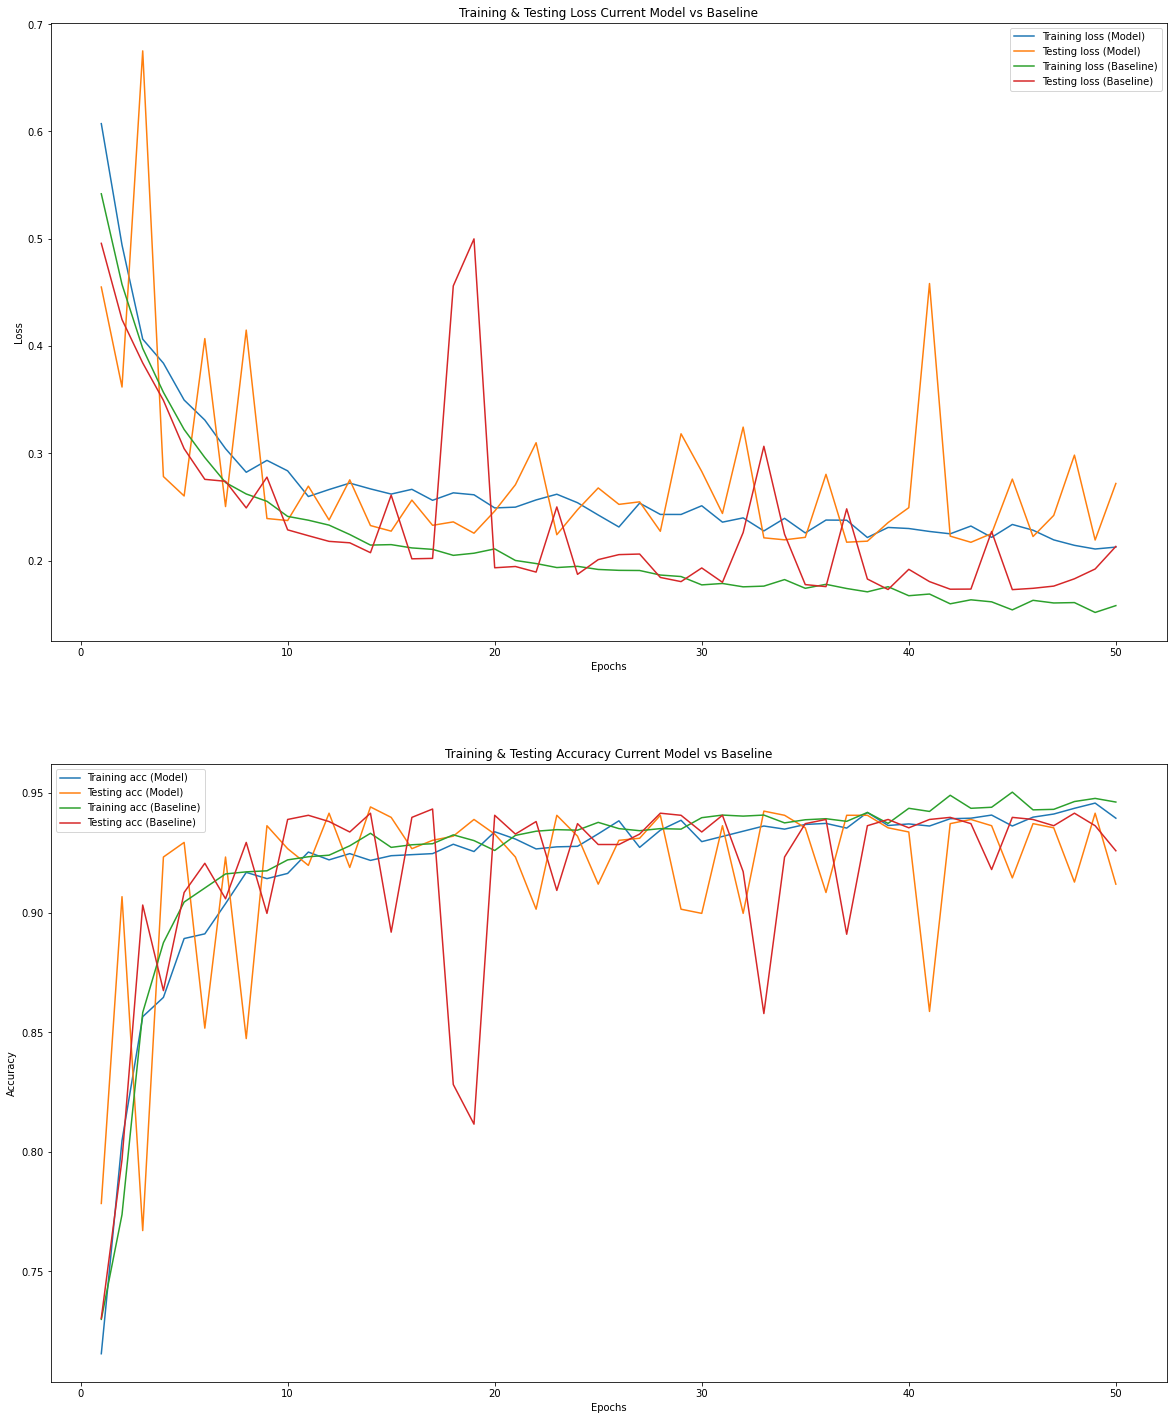

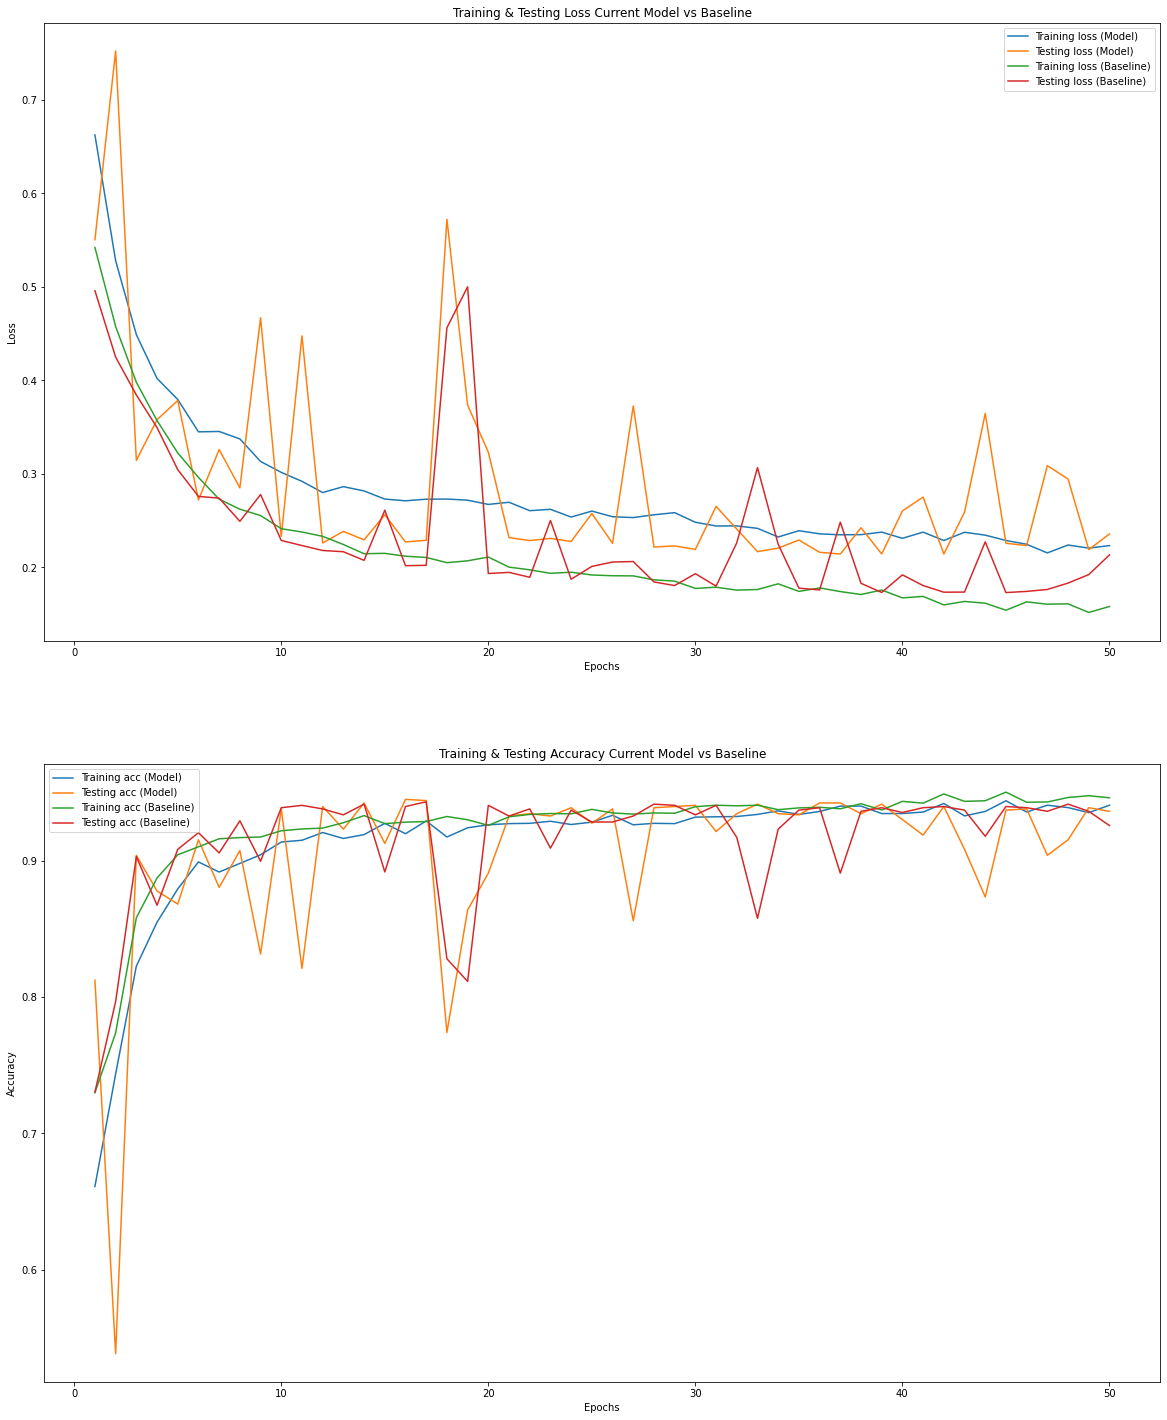

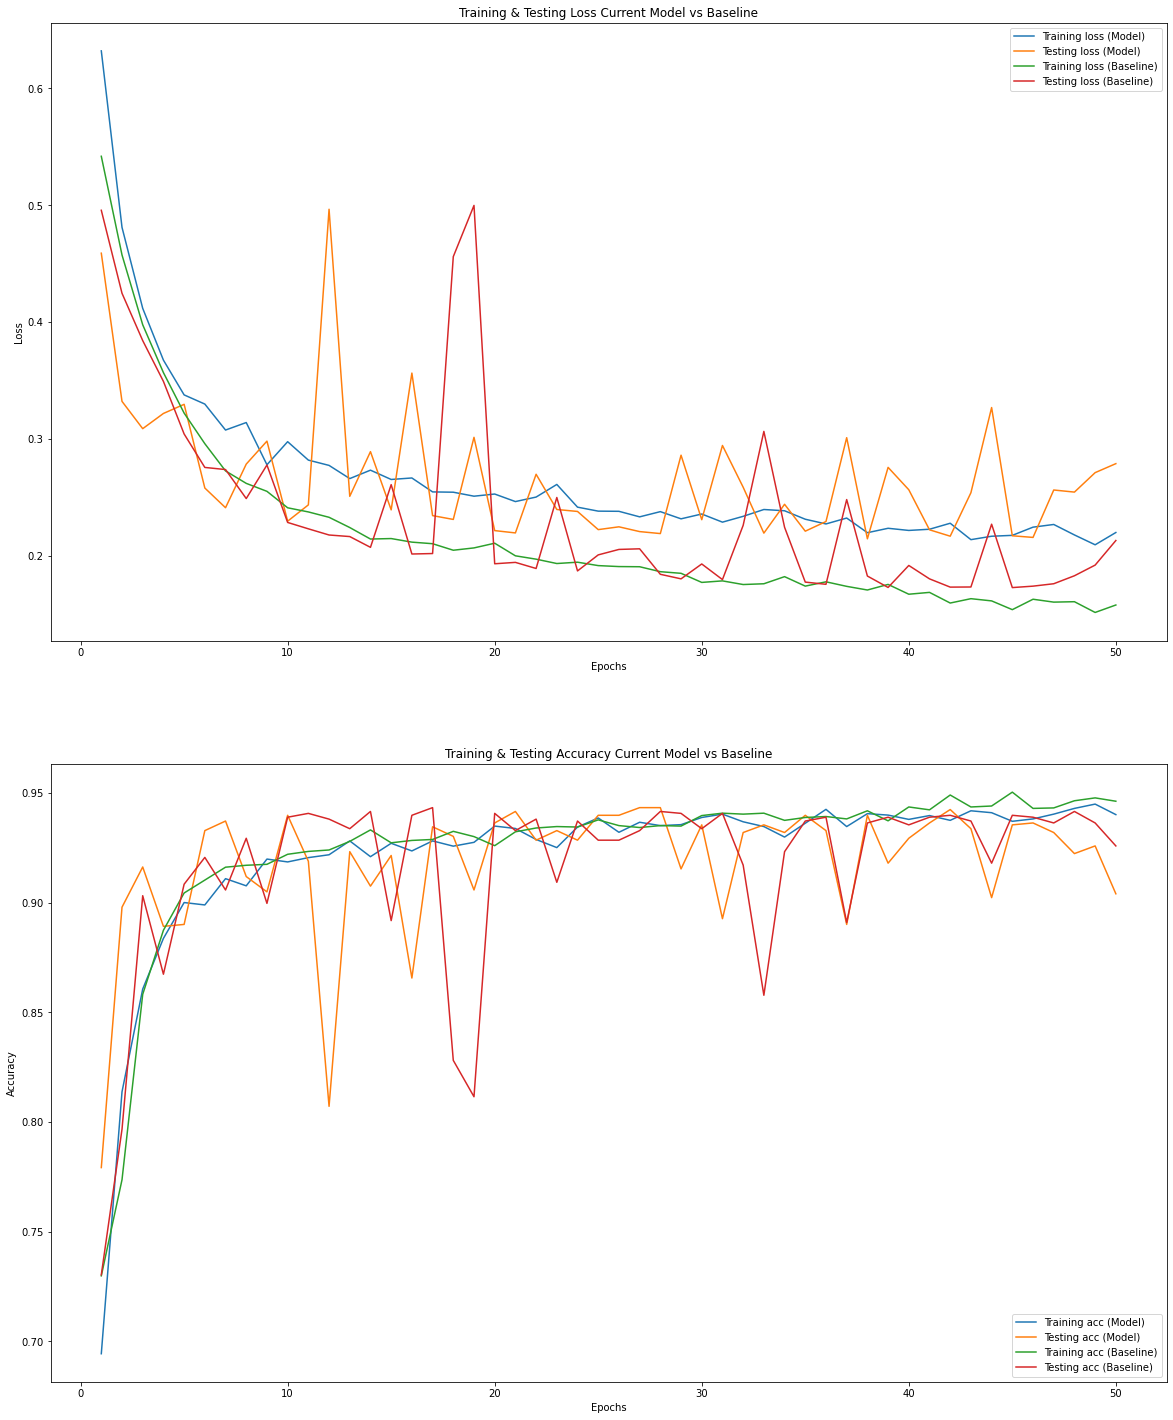

In [43]:
# Using KFold Cross Validation to fit model into 5 folds. Checking how accuracy changes based on these folds.

kf = KFold(5, shuffle=True, random_state=123)
fold=0
fold_results_1 = []
for i in kf.split(X,Y):
    fold+=1
    print("Results for fold",fold)
    
    # More complex model with an extra hidden layer, Dropout, and Regularization
    model_1 = models.Sequential()
    model_1.add(layers.Dense(20, activation='relu', kernel_regularizer=regularizers.l2(0.001), input_shape=(12288,)))
    model_1.add(layers.Dense(20, activation='relu', kernel_regularizer=regularizers.l2(0.001)))
    model_1.add(layers.Dropout(0.5))
    model_1.add(layers.Dense(1, activation='sigmoid'))
    
    model_1.compile(optimizer="sgd",
                           loss='binary_crossentropy',
                           metrics=['accuracy'])

    model_1_fit = model_1.fit(X_train,
                              y_train,
                              epochs=50,
                              batch_size=32,
                              validation_data=(X_test, y_test))
    compare_model_results(baseline_model,baseline_model_fit,model_1,model_1_fit)
    results_1 = {"Train Results:" : model_1.evaluate(X_train,y_train),"Test Results:" : model_1.evaluate(X_test, y_test)}        
    fold_results_1.append(results_1)

In [44]:
# Printing loss and accuracy for all folds

for item in range(0,len(fold_results_1)):
    print('Fold',item+1,":\n")
    pprint.pprint(fold_results_1[item])
    print('\n')

Fold 1 :

{'Test Results:': [0.2292993969006064, 0.9363001738959374],
 'Train Results:': [0.18508577658067574, 0.9501197996079286]}


Fold 2 :

{'Test Results:': [0.24686214424032607, 0.9310645718016965],
 'Train Results:': [0.19995980290929313, 0.9488128947941625]}


Fold 3 :

{'Test Results:': [0.27179394040848365, 0.9118673641228134],
 'Train Results:': [0.24837131513616562, 0.9194075365233748]}


Fold 4 :

{'Test Results:': [0.23549430917486885, 0.9363001738959374],
 'Train Results:': [0.20085735381805048, 0.9431496406011762]}


Fold 5 :

{'Test Results:': [0.2788797371986649, 0.9040139609814523],
 'Train Results:': [0.25649946306790955, 0.9091701154822074]}




Comparing our models to the ones above, we are almost fitting perfectly between train and test. Let's now see if we can attempt a CNN model using KFold to generate better results. Please note that this model will take much longer than a traditional neural network, so if the results are not improving dramatically, it is best to stick with a traditional neural network.

### Model 2: CNN Model

In [47]:
# Creating one last function to compare CNN model to baseline

def compare_model_results_CNN(baseline_model, baseline_model_fit, model, model_fit):
    
    model_baseline = baseline_model
    model_baseline_fit = baseline_model_fit
    model_func = model
    model_fit_func = model_fit
    results_train_baseline = model_baseline.evaluate(X_train, y_train)
    results_test_baseline = model_baseline.evaluate(X_test, y_test)
    results_train_model = model_func.evaluate(train_images, y_train)
    results_test_model = model_func.evaluate(test_images, y_test)
    
    baseline_model_val_dict = model_baseline_fit.history
    baseline_model_val_dict.keys()
    model_val_dict = model_fit_func.history
    model_val_dict.keys()

    model_loss_values = model_val_dict['loss']
    model_val_loss_values = model_val_dict['val_loss']
    model_acc_values = model_val_dict['acc'] 
    model_val_acc_values = model_val_dict['val_acc']
    model_epochs = range(1, len(model_loss_values) + 1)
    
    baseline_loss_values = baseline_model_val_dict['loss']
    baseline_val_loss_values = baseline_model_val_dict['val_loss']
    baseline_acc_values = baseline_model_val_dict['acc'] 
    baseline_val_acc_values = baseline_model_val_dict['val_acc']
    baseline_epochs = range(1, len(baseline_loss_values) + 1)
    
    fig, (ax, ax2) = plt.subplots(nrows=2, ncols=1, figsize=(20, 25))
    
    ax.plot(model_epochs, model_loss_values, label='Training loss (Model)')
    ax.plot(model_epochs, model_val_loss_values, label='Testing loss (Model)')
    ax.plot(baseline_epochs, baseline_loss_values, label='Training loss (Baseline)')
    ax.plot(baseline_epochs, baseline_val_loss_values, label='Testing loss (Baseline)')
    ax.set_title('Training & Validation Loss Current Model vs Baseline')
    ax.set_xlabel('Epochs')
    ax.set_ylabel('Loss')
    ax.legend();

    ax2.plot(model_epochs, model_acc_values, label='Training acc (Model)')
    ax2.plot(model_epochs, model_val_acc_values, label='Testing acc (Model)')
    ax2.plot(baseline_epochs, baseline_acc_values, label='Training acc (Baseline)')
    ax2.plot(baseline_epochs, baseline_val_acc_values, label='Testing acc (Baseline)')
    ax2.set_title('Training & Testing Accuracy Current Model vs Baseline')
    ax2.set_xlabel('Epochs')
    ax2.set_ylabel('Accuracy')
    ax2.legend();
    
    return print("\nBaseline Model Train Results (Loss, Acc.):", results_train_baseline), print("Baseline Model Test Results (Loss, Acc.):", results_test_baseline), print("\nCurrent Model Train Results (Loss, Acc.):", results_train_model), print("Current Model Test Results (Loss, Acc.):", results_test_model)

Results for fold 1
Train on 4591 samples, validate on 1146 samples
Epoch 1/50
4591/4591 [==============================] - 16s 3ms/step - loss: 0.6851 - acc: 0.7046 - val_loss: 0.6544 - val_acc: 0.7304
Epoch 2/50
4591/4591 [==============================] - 15s 3ms/step - loss: 0.6578 - acc: 0.7286 - val_loss: 0.6469 - val_acc: 0.7304
Epoch 3/50
4591/4591 [==============================] - 14s 3ms/step - loss: 0.6483 - acc: 0.7299 - val_loss: 0.6373 - val_acc: 0.7304
Epoch 4/50
4591/4591 [==============================] - 13s 3ms/step - loss: 0.6368 - acc: 0.7299 - val_loss: 0.6241 - val_acc: 0.7304
Epoch 5/50
4591/4591 [==============================] - 13s 3ms/step - loss: 0.6160 - acc: 0.7299 - val_loss: 0.6306 - val_acc: 0.7304
Epoch 6/50
4591/4591 [==============================] - 13s 3ms/step - loss: 0.5928 - acc: 0.7299 - val_loss: 0.5598 - val_acc: 0.7304
Epoch 7/50
4591/4591 [==============================] - 14s 3ms/step - loss: 0.5728 - acc: 0.7284 - val_loss: 0.5583 - val_

4591/4591 [==============================] - 13s 3ms/step - loss: 0.5426 - acc: 0.7722 - val_loss: 0.4659 - val_acc: 0.7766
Epoch 6/50
4591/4591 [==============================] - 13s 3ms/step - loss: 0.4740 - acc: 0.8079 - val_loss: 0.4159 - val_acc: 0.8255
Epoch 7/50
4591/4591 [==============================] - 13s 3ms/step - loss: 0.4233 - acc: 0.8421 - val_loss: 0.3170 - val_acc: 0.8901
Epoch 8/50
4591/4591 [==============================] - 13s 3ms/step - loss: 0.3630 - acc: 0.8763 - val_loss: 0.2939 - val_acc: 0.9049
Epoch 9/50
4591/4591 [==============================] - 13s 3ms/step - loss: 0.3473 - acc: 0.8863 - val_loss: 0.2805 - val_acc: 0.9127
Epoch 10/50
4591/4591 [==============================] - 13s 3ms/step - loss: 0.3211 - acc: 0.9000 - val_loss: 0.2649 - val_acc: 0.9066
Epoch 11/50
4591/4591 [==============================] - 13s 3ms/step - loss: 0.3028 - acc: 0.9031 - val_loss: 0.3546 - val_acc: 0.8805
Epoch 12/50
4591/4591 [==============================] - 13s 3ms

Epoch 10/50
4591/4591 [==============================] - 12s 3ms/step - loss: 0.3276 - acc: 0.8915 - val_loss: 0.4671 - val_acc: 0.7827
Epoch 11/50
4591/4591 [==============================] - 12s 3ms/step - loss: 0.3110 - acc: 0.8944 - val_loss: 0.3242 - val_acc: 0.8988
Epoch 12/50
4591/4591 [==============================] - 12s 3ms/step - loss: 0.3116 - acc: 0.9013 - val_loss: 0.2817 - val_acc: 0.9136
Epoch 13/50
4591/4591 [==============================] - 12s 3ms/step - loss: 0.2957 - acc: 0.9107 - val_loss: 0.3406 - val_acc: 0.8534
Epoch 14/50
4591/4591 [==============================] - 12s 3ms/step - loss: 0.2906 - acc: 0.9103 - val_loss: 0.2600 - val_acc: 0.9284
Epoch 15/50
4591/4591 [==============================] - 12s 3ms/step - loss: 0.2807 - acc: 0.9155 - val_loss: 0.2719 - val_acc: 0.9250
Epoch 16/50
4591/4591 [==============================] - 12s 3ms/step - loss: 0.2680 - acc: 0.9212 - val_loss: 0.3743 - val_acc: 0.8290
Epoch 17/50
4591/4591 [=========================

Epoch 15/50
4591/4591 [==============================] - 12s 3ms/step - loss: 0.2851 - acc: 0.9127 - val_loss: 0.2310 - val_acc: 0.9346
Epoch 16/50
4591/4591 [==============================] - 12s 3ms/step - loss: 0.2690 - acc: 0.9253 - val_loss: 0.2301 - val_acc: 0.9346
Epoch 17/50
4591/4591 [==============================] - 12s 3ms/step - loss: 0.2644 - acc: 0.9220 - val_loss: 0.2270 - val_acc: 0.9354
Epoch 18/50
4591/4591 [==============================] - 12s 3ms/step - loss: 0.2720 - acc: 0.9259 - val_loss: 0.2920 - val_acc: 0.9040
Epoch 19/50
4591/4591 [==============================] - 12s 3ms/step - loss: 0.2599 - acc: 0.9242 - val_loss: 0.3229 - val_acc: 0.8831
Epoch 20/50
4591/4591 [==============================] - 12s 3ms/step - loss: 0.2554 - acc: 0.9275 - val_loss: 0.3143 - val_acc: 0.8962
Epoch 21/50
4591/4591 [==============================] - 12s 3ms/step - loss: 0.2567 - acc: 0.9246 - val_loss: 0.2152 - val_acc: 0.9398
Epoch 22/50
4591/4591 [=========================

Epoch 20/50
4591/4591 [==============================] - 13s 3ms/step - loss: 0.2741 - acc: 0.9249 - val_loss: 0.2576 - val_acc: 0.9328
Epoch 21/50
4591/4591 [==============================] - 12s 3ms/step - loss: 0.2668 - acc: 0.9262 - val_loss: 0.2406 - val_acc: 0.9302
Epoch 22/50
4591/4591 [==============================] - 12s 3ms/step - loss: 0.2711 - acc: 0.9264 - val_loss: 0.2354 - val_acc: 0.9337
Epoch 23/50
4591/4591 [==============================] - 12s 3ms/step - loss: 0.2618 - acc: 0.9301 - val_loss: 0.2274 - val_acc: 0.9346
Epoch 24/50
4591/4591 [==============================] - 12s 3ms/step - loss: 0.2540 - acc: 0.9310 - val_loss: 0.2698 - val_acc: 0.9354
Epoch 25/50
4591/4591 [==============================] - 12s 3ms/step - loss: 0.2588 - acc: 0.9325 - val_loss: 0.3323 - val_acc: 0.8613
Epoch 26/50
4591/4591 [==============================] - 12s 3ms/step - loss: 0.2502 - acc: 0.9314 - val_loss: 0.2177 - val_acc: 0.9363
Epoch 27/50
4591/4591 [=========================

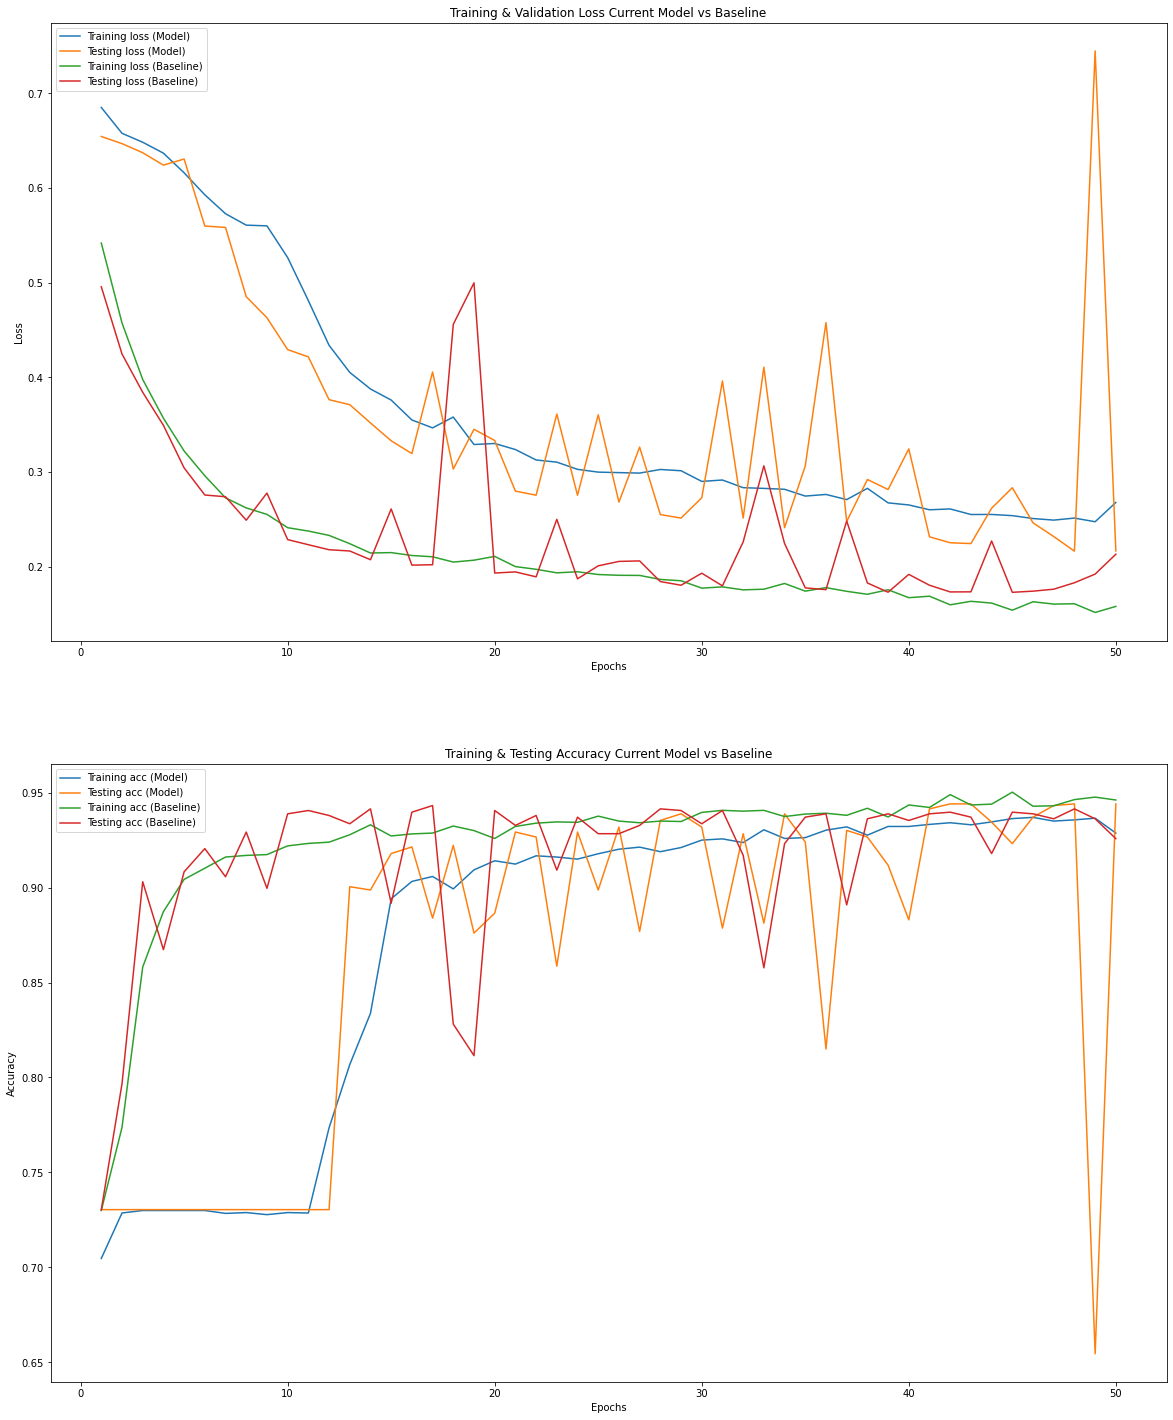

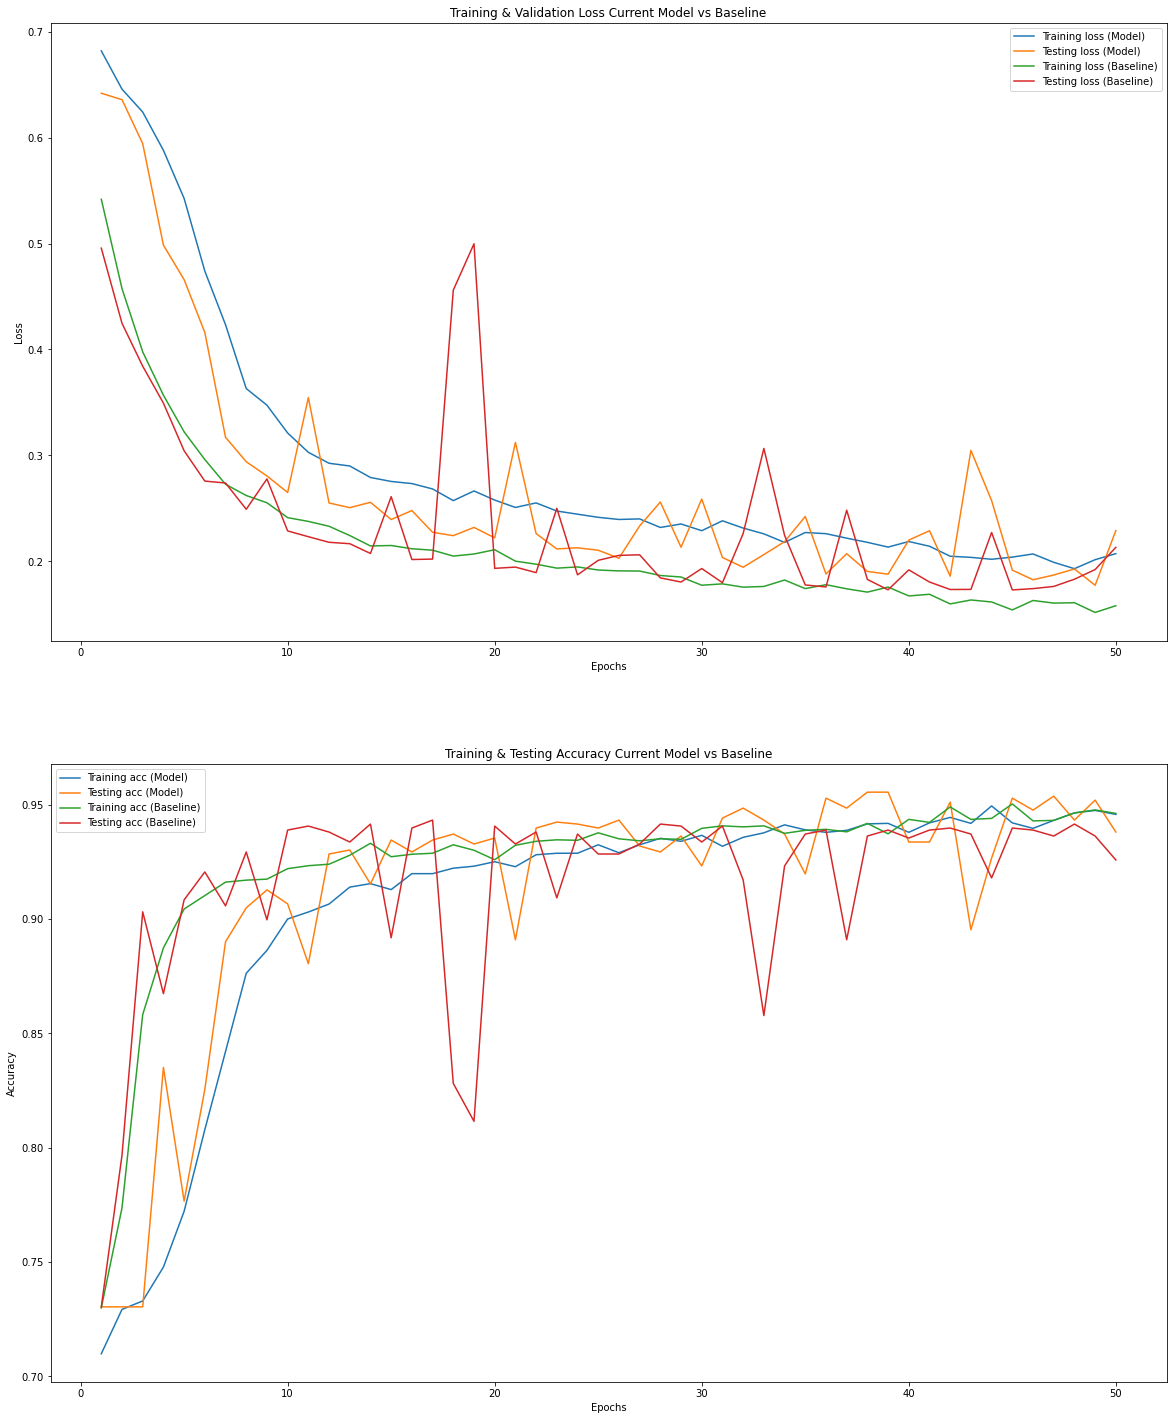

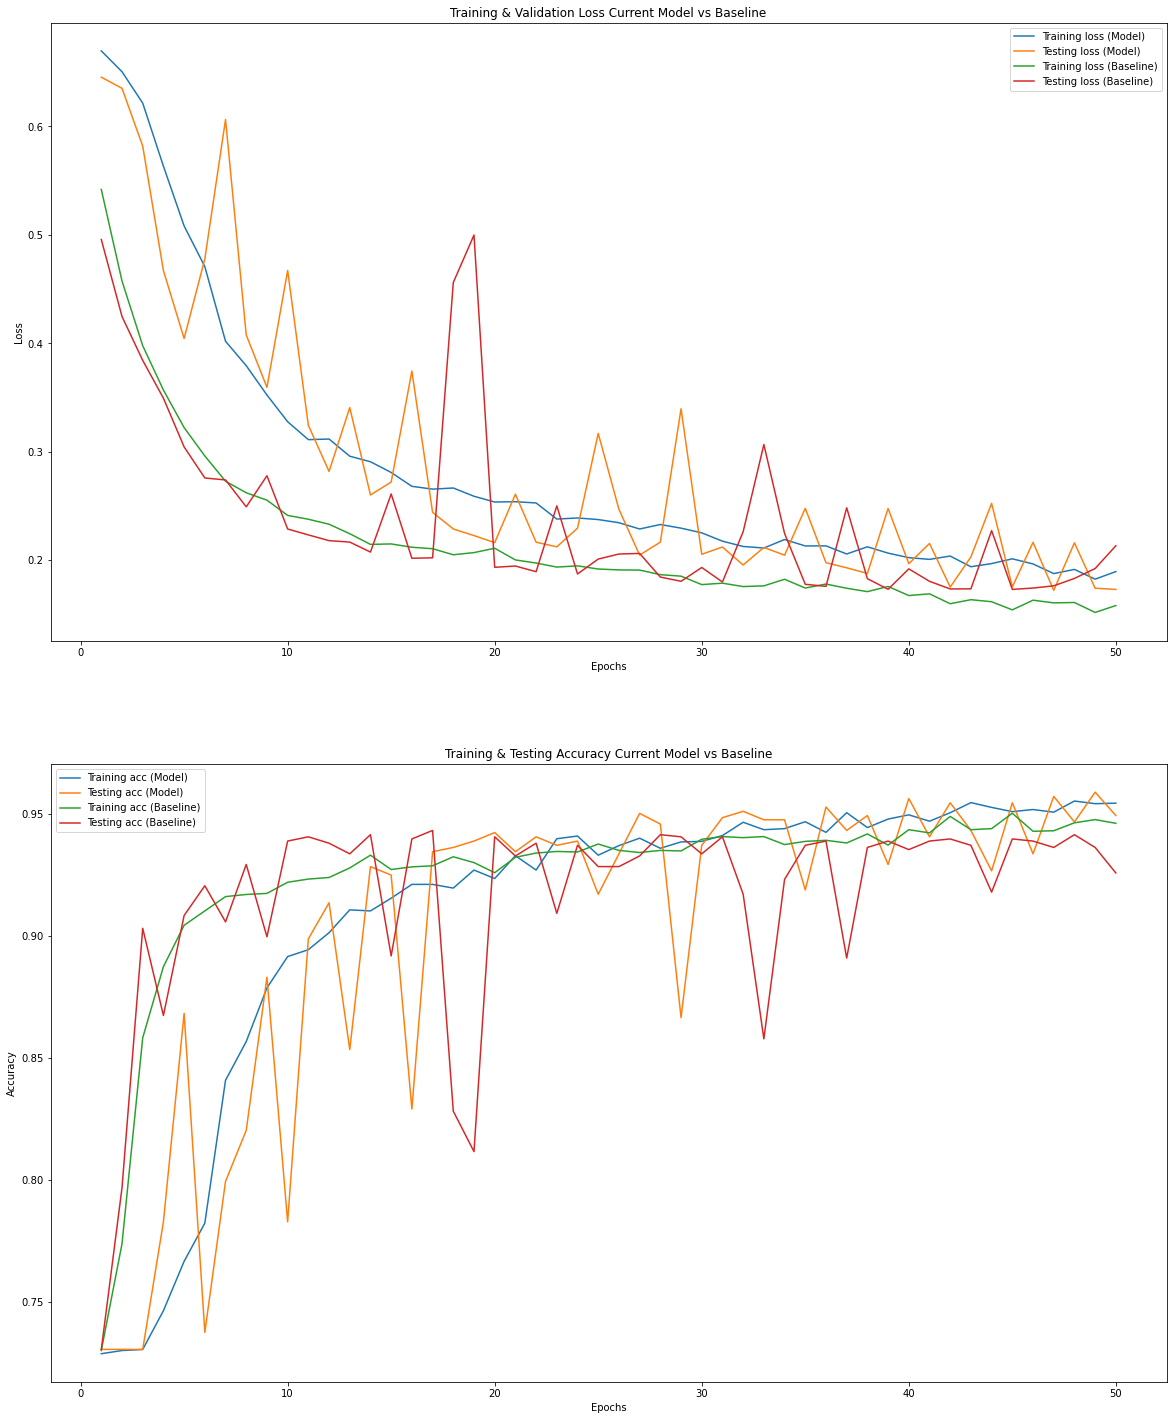

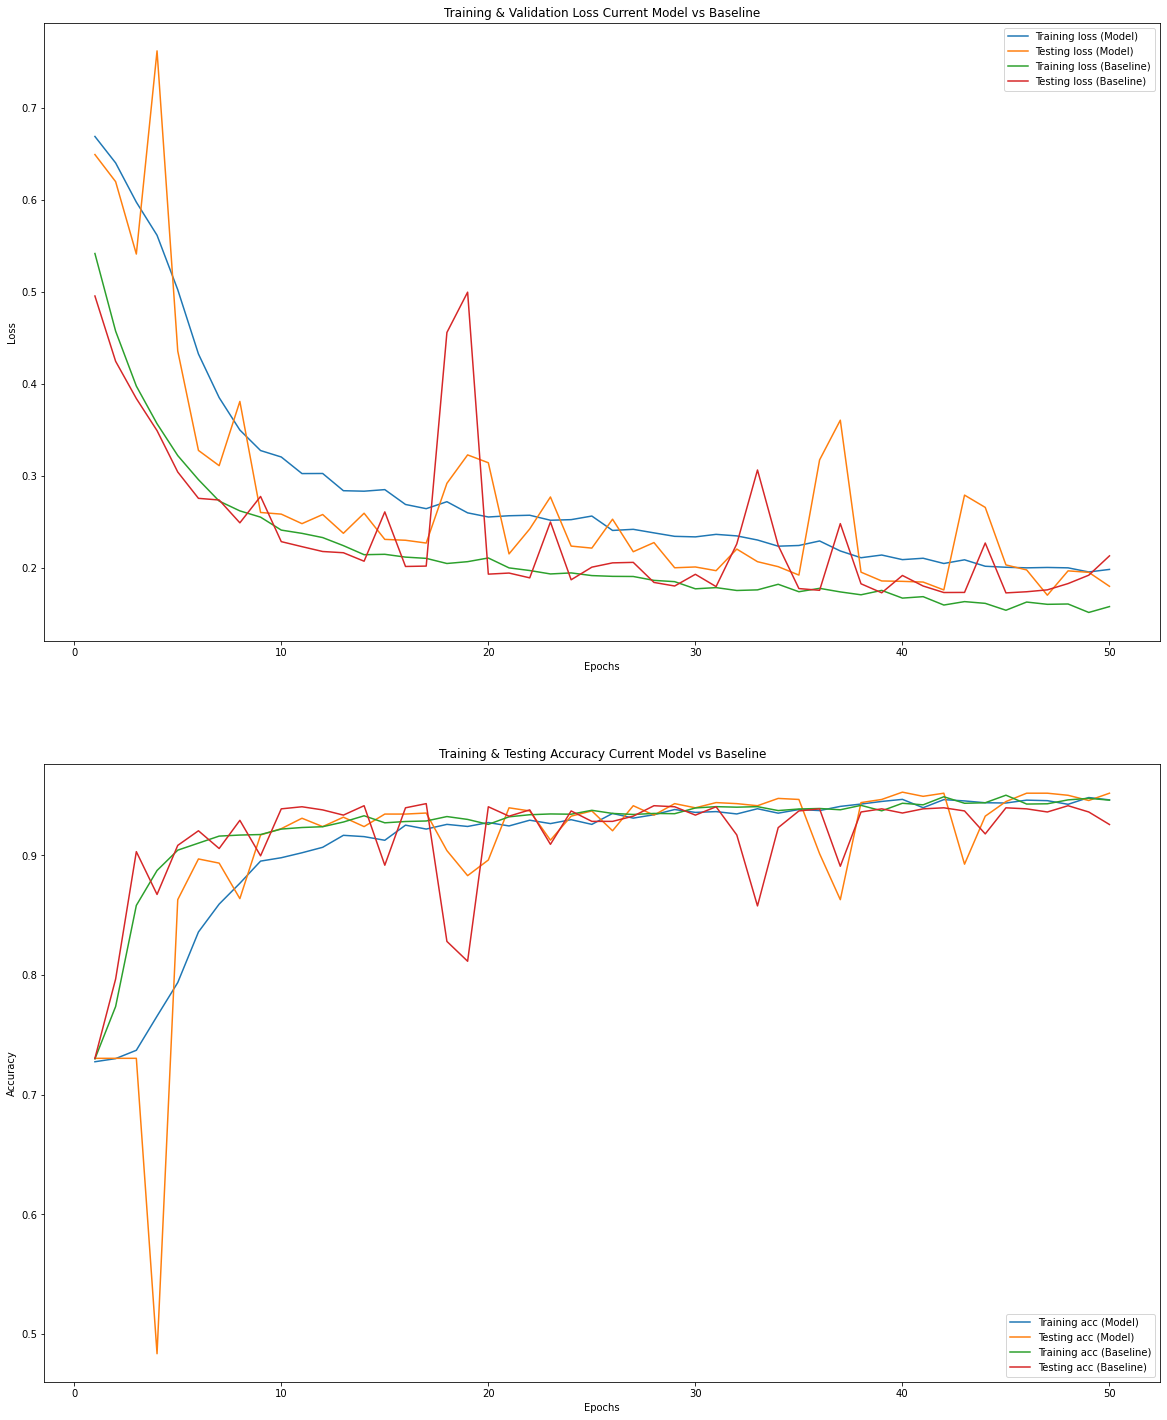

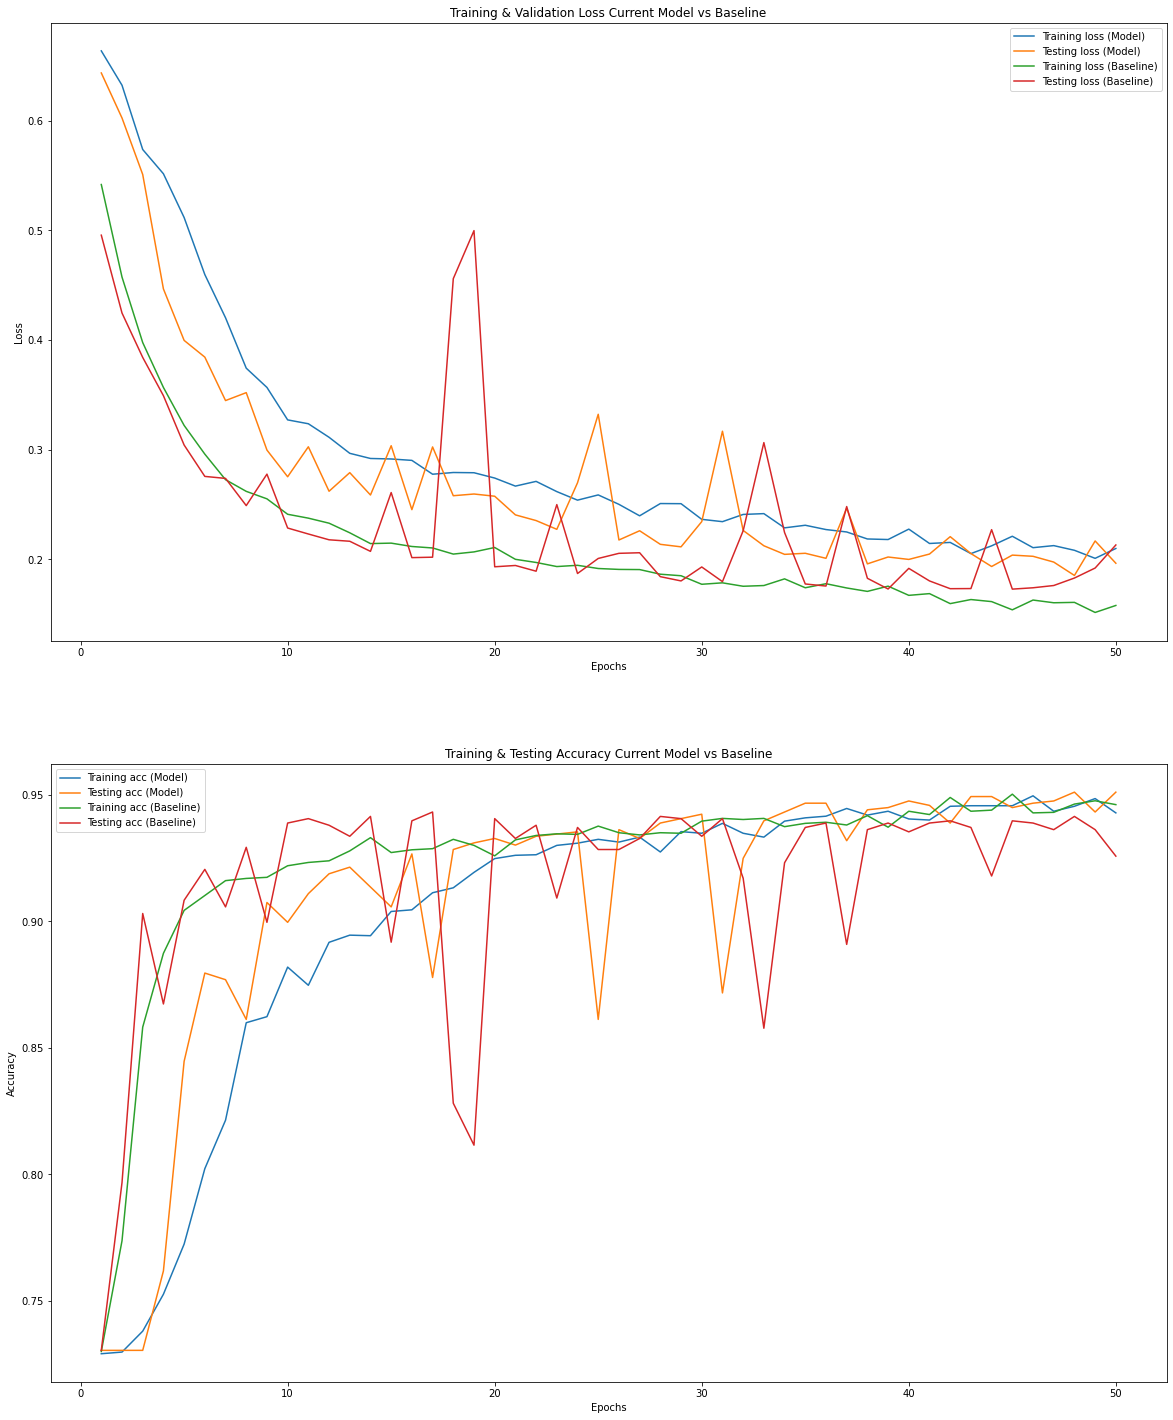

In [48]:
# KFold Cross Validation in conjuction with CNN Model

start = datetime.datetime.now()
kf = KFold(5, shuffle=True, random_state=123)
fold=0
fold_results_2 = []
for i in kf.split(X, Y):
    fold+=1
    print("Results for fold",fold)
    model_2 = models.Sequential()
    
    # Block 1
    model_2.add(layers.Conv2D(32, (3, 3), activation='relu',
                        input_shape=(64 ,64,  3)))
    model_2.add(layers.MaxPooling2D((2, 2)))
    
    #Block 2
    model_2.add(layers.Conv2D(32, (4, 4), activation='relu'))
    model_2.add(layers.MaxPooling2D((2, 2)))
    
    #Block 3
    model_2.add(layers.Conv2D(64, (3, 3), activation='relu'))
    model_2.add(layers.MaxPooling2D((2, 2)))
    
    # Dense Block
    model_2.add(layers.Flatten())
    model_2.add(layers.Dense(20, activation='relu', kernel_regularizer=regularizers.l2(0.001), input_shape=(12288,)))
    model_2.add(layers.Dense(20, activation='relu', kernel_regularizer=regularizers.l2(0.001)))
    model_2.add(layers.Dropout(0.5))
    model_2.add(layers.Dense(1, activation='sigmoid'))
    
    model_2.compile(optimizer='sgd',
                    loss='binary_crossentropy',
                    metrics=['accuracy'])

    model_2_fit = model_2.fit(train_images,
                              y_train,
                              epochs=50,
                              batch_size=32,
                              validation_data=(test_images, y_test))
    
    compare_model_results_CNN(baseline_model,baseline_model_fit,model_2,model_2_fit)
    results_2 = {"Train Results:" : model_2.evaluate(train_images,y_train),"Test Results:" : model_2.evaluate(test_images, y_test)}        
    fold_results_2.append(results_2)

In [49]:
# Check model run-time

end = datetime.datetime.now()
elapsed = end - start
print('Training with data augmentation took a total of {}'.format(elapsed))

Training with data augmentation took a total of 0:52:57.613534


In [50]:
# Print model results: Loss and Accuracy

for item in range(0,len(fold_results_2)):
    print('Fold',item+1,":\n")
    pprint.pprint(fold_results_2[item])
    print('\n')

Fold 1 :

{'Test Results:': [0.21654142855453656, 0.9441535770372986],
 'Train Results:': [0.20279987057071708, 0.9509910694837725]}


Fold 2 :

{'Test Results:': [0.22888071015867265, 0.9380453745940177],
 'Train Results:': [0.2202661924179383, 0.9326944020910477]}


Fold 3 :

{'Test Results:': [0.17284238736354868, 0.9493891791315395],
 'Train Results:': [0.15459524097330454, 0.9623175778827281]}


Fold 4 :

{'Test Results:': [0.1799898976638887, 0.9520069801786599],
 'Train Results:': [0.16929529276880348, 0.9566543236767588]}


Fold 5 :

{'Test Results:': [0.19644602792529328, 0.9511343798296198],
 'Train Results:': [0.17017031406309838, 0.9509910694837725]}




Looking at our results, it appears there is not much change. Let's compare all of our models and check the results.

# Section 5: Results

Before selecting our best model, let's compare the results between our two models.

In [51]:
# Creating a function that compares fold results between our CNN Model and Standard Neural Network Model 1 

def average_list(list):
    return sum(list)/len(list)

def fold_average(model1,model2,data, metric):
    if metric == 'Accuracy':
        if data == "Train":
            accuracy_list_1 = []
            for i in range(0,5):
                accuracy_list_1.append(list(model1[i].items())[0][1][1])
            print("Model 1 Average Accuracy:",average_list(accuracy_list_1))
            accuracy_list_2 = []
            for i in range(0,5):
                accuracy_list_2.append(list(model2[i].items())[0][1][1])
            print("Model 2 Average Accuracy:",average_list(accuracy_list_2))
            print('Difference between 2 Models:',abs(average_list(accuracy_list_2)-average_list(accuracy_list_1)))
        if data == "Test":
            accuracy_list_1 = []
            for i in range(0,5):
                accuracy_list_1.append(list(model1[i].items())[1][1][1])
            print("Model 1 Average Accuracy:",average_list(accuracy_list_1))
            accuracy_list_2 = []
            for i in range(0,5):
                accuracy_list_2.append(list(model2[i].items())[1][1][1])
            print("Model 2 Average Accuracy:",average_list(accuracy_list_2))
            print('Difference between 2 Models:',abs(average_list(accuracy_list_2)-average_list(accuracy_list_1)))
            
    if metric == 'Loss':
        if data == "Train":
            loss_list_1 = []
            for i in range(0,5):
                loss_list_1.append(list(model1[i].items())[0][1][0])
            print("Model 1 Average Loss:",average_list(loss_list_1))
            loss_list_2 = []
            for i in range(0,5):
                loss_list_2.append(list(model2[i].items())[0][1][0])
            print("Model 2 Average Loss:",average_list(loss_list_2))
            print('Difference between 2 Models:',abs(average_list(loss_list_2)-average_list(loss_list_1)))
        if data == "Test":
            loss_list_1 = []
            for i in range(0,5):
                loss_list_1.append(list(model1[i].items())[1][1][0])
            print("Model 1 Average Loss:",average_list(loss_list_1))
            loss_list_2 = []
            for i in range(0,5):
                loss_list_2.append(list(model2[i].items())[1][1][0])
            print("Model 2 Average Loss:",average_list(loss_list_2))
            print('Difference between 2 Models:',abs(average_list(loss_list_2)-average_list(loss_list_1)))

In [54]:
# Print Results using function above

for data in ['Train','Test']:
    print(data)
    fold_average(fold_results_1,fold_results_2,data,'Accuracy')
    print('\n')

Train
Model 1 Average Accuracy: 0.9341319974017699
Model 2 Average Accuracy: 0.9507296885236161
Difference between 2 Models: 0.01659769112184617


Test
Model 1 Average Accuracy: 0.9239092489395674
Model 2 Average Accuracy: 0.9469458981542271
Difference between 2 Models: 0.023036649214659755




In [55]:
# Print Results using function above

for data in ['Train','Test']:
    print(data)
    fold_average(fold_results_1,fold_results_2,data,'Loss')
    print('\n')

Train
Model 1 Average Loss: 0.2181547423024189
Model 2 Average Loss: 0.18342538215877235
Difference between 2 Models: 0.034729360143646554


Test
Model 1 Average Loss: 0.25246590558459
Model 2 Average Loss: 0.198940090333188
Difference between 2 Models: 0.05352581525140199




As we can see in the comparision of our models, the CNN model has slightly better accuracy and loss than our standard neural network. However, looking at the time it took to run the CNN model with KFold Cross Validation (around 50 minutes) it does not seem justifiable to use model 2 over model 1, despite our model performing better by around 3% accuracy.

In [56]:
# Predict final y variables using selected model

final_val = model_1.predict(X_val)
final_train = model_1.predict(X_train)

In [57]:
# Reformat to 0s and 1s

final_train[final_train <= 0.5] = 0.
final_train[final_train > 0.5] = 1.

In [58]:
# Reformat to 0s and 1s

final_val[final_val <= 0.5] = 0.
final_val[final_val > 0.5] = 1.

In [59]:
# Print classification report for train and holdout data (validation set)

print("Training Data Results:\n")
print(classification_report(y_train, final_train))
print("Holdout Data Results:\n")
print(classification_report(y_val, final_val))

Training Data Results:

              precision    recall  f1-score   support

         0.0       0.98      0.89      0.93      3351
         1.0       0.76      0.96      0.85      1240

    accuracy                           0.91      4591
   macro avg       0.87      0.93      0.89      4591
weighted avg       0.92      0.91      0.91      4591

Holdout Data Results:

              precision    recall  f1-score   support

         0.0       0.99      0.89      0.94        85
         1.0       0.79      0.97      0.87        34

    accuracy                           0.92       119
   macro avg       0.89      0.93      0.90       119
weighted avg       0.93      0.92      0.92       119



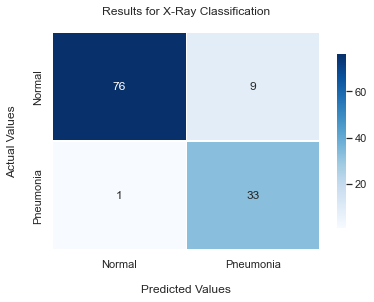

In [60]:
# Create confusion matrix for final model 
lrcm = confusion_matrix(y_val, final_val)
sns.set_context("talk")
sns.set_theme(style='darkgrid')
ax = sns.heatmap(lrcm, annot=True, cmap='Blues',fmt = 'g',linewidth=0.3, cbar_kws={"shrink": .8})

ax.set_title('Results for X-Ray Classification\n');
ax.set_xlabel('\nPredicted Values')
ax.set_ylabel('Actual Values\n');

## Ticket labels - List must be in alphabetical order
ax.xaxis.set_ticklabels(["Normal","Pneumonia"])
ax.yaxis.set_ticklabels(["Normal","Pneumonia"])
## Display the visualization of the Confusion Matrix.
plt.savefig('Visualizations/ConfusionMatrix.png', bbox_inches = 'tight')
plt.show()

As we can see above, our recall metric related to class 1 is pretty high. This means that for our 34 patients that actually had pneumonia, only 2 of them were incorrectly classified as normal. This 97% recall rate appears to strengthen our capabilities of classification. While there is a small number of misclassification that is likely to cause patient readmission, this model will generally help solve our business problem of reducing the large amount of readmissions to hospitals due to pneumonia.